### Importing Required Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import export_graphviz
import pydot
from subprocess import check_call

### Reading the dataset

In [2]:
temp = pd.read_csv('temps.csv')
temp = temp.drop(['forecast_noaa', 'forecast_acc', 'forecast_under'], axis=1)
temp.head()

,year,month,day,week,temp_2,temp_1,average,actual,friend
0,2016,1,1,Fri,45,45,45.6,45,29
1,2016,1,2,Sat,44,45,45.7,44,61
2,2016,1,3,Sun,45,44,45.8,41,56
3,2016,1,4,Mon,44,41,45.9,40,53
4,2016,1,5,Tues,41,40,46.0,44,41


### Exploratory Visualizations

The **x** axis in each graph corresponds to the number of days in the year 2016.

(0.0, 1.0, 0.0, 1.0)

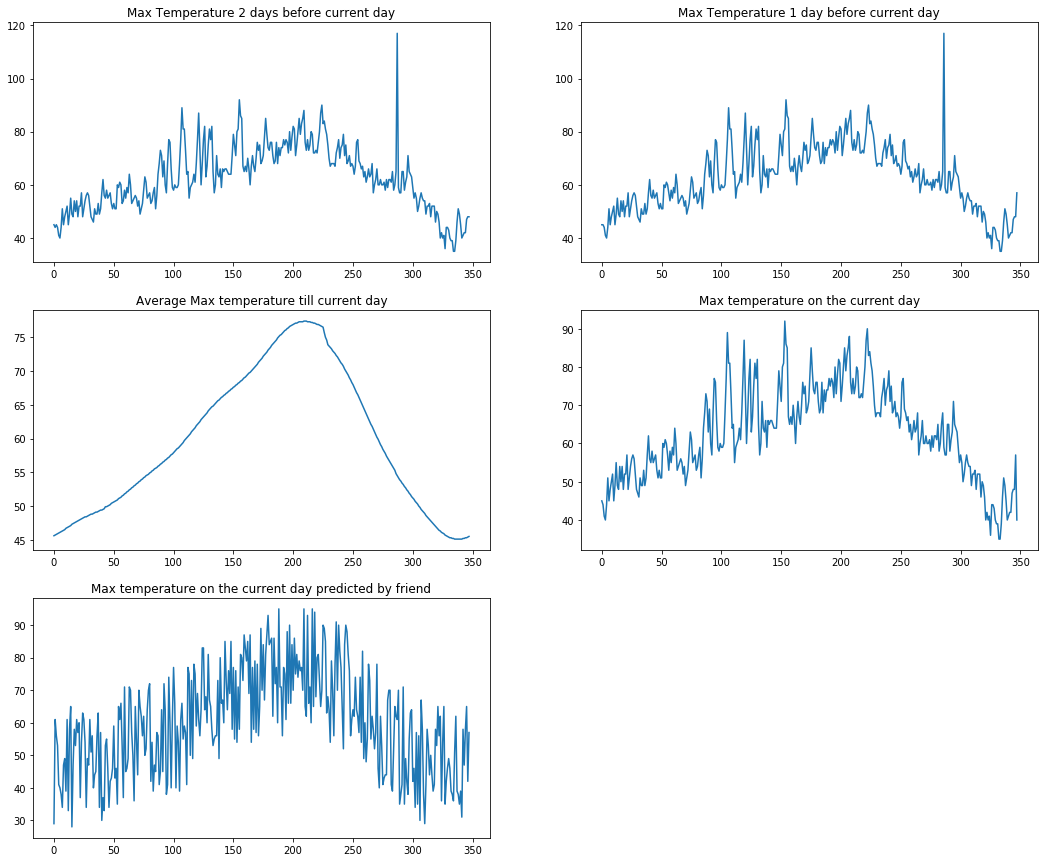

In [3]:
plt.rcParams['figure.figsize'] = 18,15
fig, ax = plt.subplots(3,2)

ax[0, 0].plot(temp['temp_2'])
ax[0, 0].set_title('Max Temperature 2 days before current day')

ax[0, 1].plot(temp['temp_1'])
ax[0, 1].set_title('Max Temperature 1 day before current day')

ax[1, 0].plot(temp['average'])
ax[1, 0].set_title('Average Max temperature till current day')

ax[1, 1].plot(temp['actual'])
ax[1, 1].set_title('Max temperature on the current day')

ax[2, 0].plot(temp['friend'])
ax[2, 0].set_title('Max temperature on the current day predicted by friend')

ax[2, 1].axis('off')

The first 2 graphs corrsponding to the **Max Temperature 2 days before current day** and **Max Temperature 1 day before current day** contain an outlier (at a glance).

### Cleaning the dataset / Dealing with the outliers.

In [4]:
temp[temp['temp_1'] == temp['temp_1'].max()]

,year,month,day,week,temp_2,temp_1,average,actual,friend
286,2016,10,31,Mon,65,117,54.8,59,62


In [5]:
temp[temp['temp_2'] == temp['temp_2'].max()]

,year,month,day,week,temp_2,temp_1,average,actual,friend
287,2016,11,1,Tues,117,59,54.5,57,61


These values show that the temperature recorded one day prior to **2016-10-31** and 2 days prior to **2016-11-1** is a **117** degrees. However, in the cell below we can clearly see that the actual temperature recorded for the day in question (**2016-10-29**) was **68** degrees. 

In [6]:
temp.iloc[285]

year       2016
month        10
day          29
week        Sat
temp_2       60
temp_1       65
average    55.3
actual       68
friend       65
Name: 285, dtype: object

In the cell below the ambigious temperatures have been modified to match the actual temerature recorded. 

In [7]:
temp.at[286, 'temp_1'] = 68
temp.at[287, 'temp_2'] = 68

The plots below confirm the absence of outliers after the cleaning process is done.

(0.0, 1.0, 0.0, 1.0)

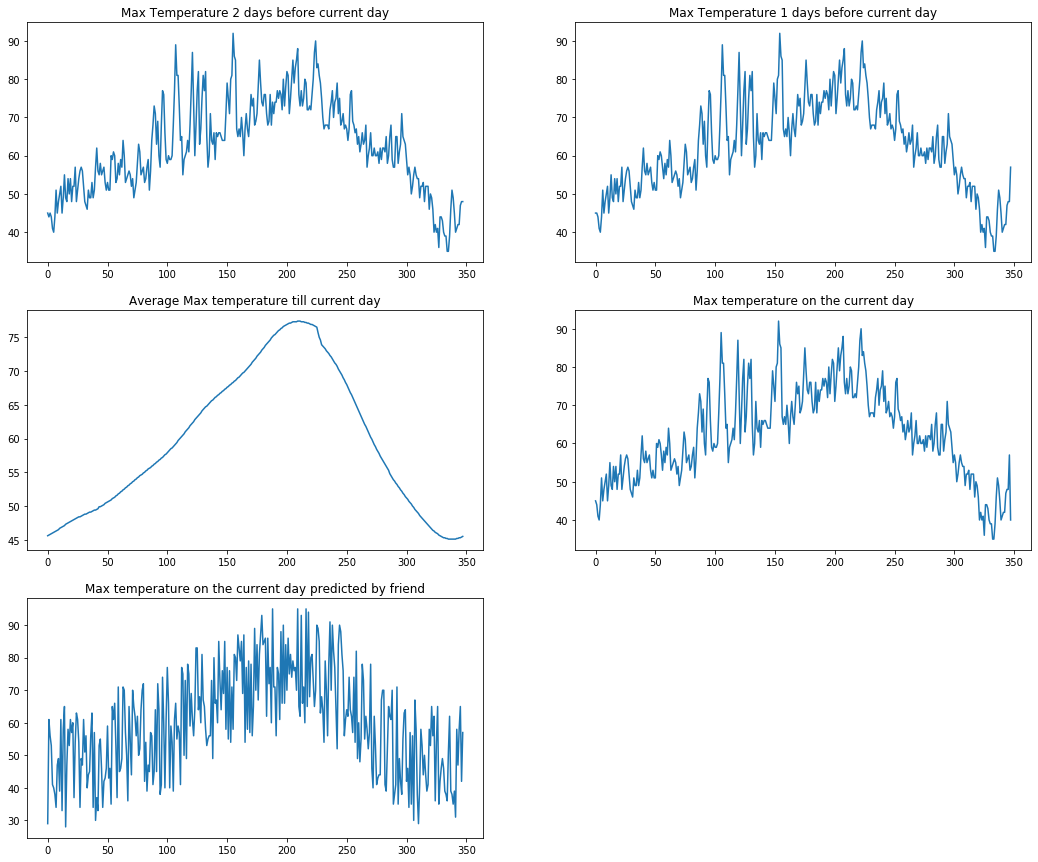

In [8]:
plt.rcParams['figure.figsize'] = 18,15
fig, ax = plt.subplots(3,2)

ax[0, 0].plot(temp['temp_2'])
ax[0, 0].set_title('Max Temperature 2 days before current day')

ax[0, 1].plot(temp['temp_1'])
ax[0, 1].set_title('Max Temperature 1 days before current day')

ax[1, 0].plot(temp['average'])
ax[1, 0].set_title('Average Max temperature till current day')

ax[1, 1].plot(temp['actual'])
ax[1, 1].set_title('Max temperature on the current day')

ax[2, 0].plot(temp['friend'])
ax[2, 0].set_title('Max temperature on the current day predicted by friend')

ax[2, 1].axis('off')

### Data Preparation.
Before using the data in the model, we must preprocess it. In this dataset, the weeks are recorded in the form of strings, that are intuitive enough for humans but not likewise for machine learning models. Thus, this variable is encoded using the principle of **One Hot Encoding**.

In [9]:
week_dummies = pd.get_dummies(temp['week'])
temp_encoded = pd.concat([temp, week_dummies], axis=1)
temp_encoded = temp_encoded.drop(['week'], axis=1)
temp_encoded.head()

,year,month,day,temp_2,temp_1,average,actual,friend,Fri,Mon,Sat,Sun,Thurs,Tues,Wed
0,2016,1,1,45,45,45.6,45,29,1,0,0,0,0,0,0
1,2016,1,2,44,45,45.7,44,61,0,0,1,0,0,0,0
2,2016,1,3,45,44,45.8,41,56,0,0,0,1,0,0,0
3,2016,1,4,44,41,45.9,40,53,0,1,0,0,0,0,0
4,2016,1,5,41,40,46.0,44,41,0,0,0,0,0,1,0


### Training and Testing datasets.  

The values in the **actual** column need to be predicted using Random Forests model. Thus all features except **actual** are stored in a dataframe with the name **features**, and the **actual** values are stored in a dataframe named **targets**.

In [10]:
features = temp_encoded.drop(['actual'], axis=1)
targets = temp_encoded['actual']

Training and Testing targets and features are extracted in this step and the sizes of the resulting dataframes are shown below. 

In [11]:
train_features, test_features, train_targets, test_targets = train_test_split(features, targets, test_size = 0.25, random_state = 42)

In [12]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_targets.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', train_targets.shape)

Training Features Shape: (261, 14)
Training Labels Shape: (261,)
Testing Features Shape: (87, 14)
Testing Labels Shape: (261,)


### Extablishing Baseline Errors.
If our model can not surpass this performance, then we need to look at other models.

In [13]:
baseline_preds = test_features['average']
baseline_errors = abs(baseline_preds - test_targets)

print('Average baseline error: ', round(np.mean(baseline_errors), 2))

Average baseline error:  5.06


### Random Forests Model.
The random forests are instantiated and trained on the training features and targets.

In [14]:
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
rf.fit(train_features, train_targets)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1000, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

Predictions on the test features are made and compared with the actual testing targets.

In [15]:
predictions = rf.predict(test_features)
errors = abs(predictions - test_targets)

print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

Mean Absolute Error: 3.83 degrees.


The model clearly outperforms the baseline established earlier.

Here, a formal accuracy measure is defined for the model.

In [16]:
mape = 100 * (errors / test_targets)
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 93.99 %.


### Feature Importance.

In [17]:
importances = np.round(rf.feature_importances_, 2)
for i, imp in enumerate(importances):
    print("Feature: "+features.columns[i]+"\tImportance: "+str(imp))

Feature: year	Importance: 0.0
Feature: month	Importance: 0.01
Feature: day	Importance: 0.03
Feature: temp_2	Importance: 0.02
Feature: temp_1	Importance: 0.7
Feature: average	Importance: 0.19
Feature: friend	Importance: 0.02
Feature: Fri	Importance: 0.0
Feature: Mon	Importance: 0.0
Feature: Sat	Importance: 0.0
Feature: Sun	Importance: 0.0
Feature: Thurs	Importance: 0.0
Feature: Tues	Importance: 0.0
Feature: Wed	Importance: 0.0


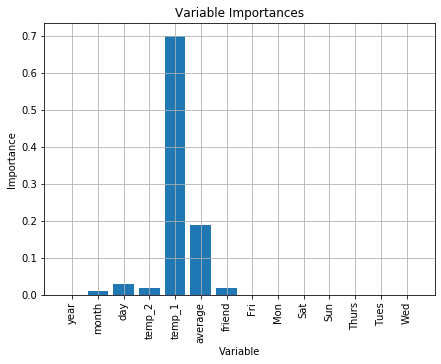

In [18]:
plt.rcParams['figure.figsize'] = 7, 5

x_values = list(range(len(importances)))

plt.bar(x_values, importances, orientation = 'vertical')
plt.xticks(x_values, features.columns, rotation='vertical')

plt.ylabel('Importance')
plt.xlabel('Variable')
plt.title('Variable Importances');

plt.grid()
plt.show()

From the above data it is clear that **temp_1** and **average** are the 2 most important features to consider. In the next section Random Forests are built with just these 2 features.

In [19]:
imp_features = temp_encoded[['temp_1', 'average']]
targets = temp_encoded['actual']

train_imp_features, test_imp_features, train_targets, test_targets = train_test_split(imp_features, targets, test_size = 0.25, random_state = 42)

imp_rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
imp_rf.fit(train_imp_features, train_targets)

imp_predictions = imp_rf.predict(test_imp_features)
imp_errors = abs(imp_predictions - test_targets)
print('Mean Absolute Error:', round(np.mean(imp_errors), 2), 'degrees.')

imp_mape = 100 * (imp_errors / test_targets)
imp_accuracy = 100 - np.mean(imp_mape)
print('Accuracy:', round(imp_accuracy, 2), '%.')

Mean Absolute Error: 3.92 degrees.
Accuracy: 93.77 %.


Clearly the accuracy is not that different from when all the features of the dataset were utilized.

### Ploting the Decision Trees of the Random Forest.

In [20]:
tree = rf.estimators_[34]
export_graphviz(tree, out_file = 'tree.dot', feature_names = features.columns, rounded = True, precision = 1)

In the section below, we build Random Forests out of Decision Trees that have **max_depth** set as 3. This helps us to analyse the features a bit more closely.

In [21]:
rf_small = RandomForestRegressor(n_estimators=10, max_depth = 3)
rf_small.fit(train_features, train_targets)

tree_small = rf_small.estimators_[5]

export_graphviz(tree_small, out_file = 'small_tree.dot', feature_names = features.columns, rounded = True, precision = 1)